In [1]:
import ast
from collections import Counter
import csv
import datetime
from sklearn.gaussian_process.kernels import RBF
from hyperopt import STATUS_OK, hp, tpe, Trials, fmin
from hyperopt.pyll.stochastic import sample
from imblearn.over_sampling import SMOTE 
import lightgbm  as  lgb
from lightgbm import LGBMClassifier
from matplotlib.dates import DateFormatter
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, PercentFormatter, StrMethodFormatter
import numpy as np
from sklearn.neural_network import MLPClassifier
import pandas as pd
import seaborn as sns
from pathlib import Path
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    SCORERS,  # # sorted(SCORERS.keys())
    confusion_matrix,
    classification_report,
    plot_confusion_matrix,
    roc_curve
)
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import SGDClassifier, LogisticRegression, LassoCV
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, binarize
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBClassifier
import time
from timeit import default_timer as timer
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
%matplotlib inline

C:\Users\ThomasWiddows\Anaconda3\envs\sb_ultimate_take_home\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
rs = 3 # random state

DATA_DIR = Path.cwd() / 'data'
MAX_EVALS =  5
N_FOLDS = 5

# Algorithms to try
classification_algos_name = [
#     "SVC",
#     "SVC",
    "KNeighborsClassifier",
    "GaussianNB",
#     "MultinomialNB",
#     "BernoulliNB",
    "DecisionTreeClassifier",
    "ExtraTreeClassifier",
#     "LinearDiscriminantAnalysis",
    "RandomForestClassifier",
    "AdaBoostClassifier",
    "GradientBoostingClassifier",
#     "QuadraticDiscriminantAnalysis",
#     "MLPClassifier",
#     "GaussianProcessClassifier",
    "XGBClassifier",
    "LGBMClassifier",
]

classification_algos = [
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
    KNeighborsClassifier(20),
    GaussianNB(),
#     MultinomialNB(),
#     BernoulliNB(binarize=.2, fit_prior=True),
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
#     LinearDiscriminantAnalysis(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
#     QuadraticDiscriminantAnalysis(),
#     MLPClassifier(alpha=1, max_iter=1000),
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
    XGBClassifier(),
    LGBMClassifier(),
]

Utility functions

In [3]:
# save pickle
def save_obj(obj, name):
    import pickle
    with open(DATA_DIR / str(name + '.pkl'), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# load pickle
def load_obj(name ):
    import pickle
    with open(DATA_DIR / str(name + '.pkl'), 'rb') as f:
        return pickle.load(f)

# print blank lines
def bl(qty=1):
    for l in range(qty):
        print()

def df_summary(df):
    display(df.head())
    display(df.describe())
    df.info()

Helper functions

In [4]:
# return best thresholds
def cutoff_youdens_j(fpr,tpr,thresholds):
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]
    
# plot histogram of predicted probability
def pred_prob_hist(X_valid, bins=8, xlabel='positive', cutoff=0.5):
    plt.hist(y_pred_prob, bins=bins)
    plt.xlim(0,1)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_major_formatter(PercentFormatter(1))
    ax.axvline(x=cutoff, ymin=0, ymax=1, color='r', linewidth=3,  linestyle='--')
    plt.title("Histogram of predicted probabilities")
    plt.xlabel("Predicted probability of "+xlabel)
    plt.ylabel('Frequency');
    colors = ['darkred']
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in colors]
    labels = ['Cutoff']
    plt.legend(lines, labels)
    plt.show();
    bl()

    
# plot feature importances
def feat_imp_plot(df, model, n_features, max_features=30):
    n_features = min(n_features, max_features)
    d = dict(zip(df.columns, model.feature_importances_))
    ss = sorted(d, key=d.get, reverse=True)
    top_names = ss[0:n_features]
    plt.figure(figsize=(15, 5))
    plt.title("Feature importances")
    plt.bar(range(n_features), [d[i] for i in top_names], color="r", align="center")
    plt.xlim(-1, n_features)
    plt.xticks(range(n_features), top_names, rotation="vertical")

    
# draw diag line
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')


# plot roc curve
def plot_roc_curve(y_valid, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_prob.ravel())
    optimal_cutoff = cutoff_youdens_j(fpr,tpr,thresholds)
    y_pred_class = binarize(y_pred_prob.reshape(1,-1), optimal_cutoff) 
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred_class.ravel()).ravel()
    false_positive_rate = fp / (fp + tn)
    true_positive_rate = tp / (tp + fn)

    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.gca().set_aspect('equal', adjustable='box')
    ax = plt.gca()
    ax.xaxis.set_major_formatter(PercentFormatter(1))
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    plt.xticks(fontsize=12, rotation=0)
    plt.yticks(fontsize=12, rotation=0)
    plt.title('ROC curve for retained customers\n', fontsize=16)
    plt.xlabel('False Positive Rate\nFP / (FP + TN)', fontsize=14)  # : (1 - Specificity)
    plt.ylabel('True Positive Rate (Recall)\nTP / (TP + FN)', fontsize=14)  # : (Recall)
    plt.grid(True)
    abline(slope=1,intercept=0)
    ax.axvline(x=false_positive_rate, ymin=0, ymax=true_positive_rate, color='r', linestyle='--')
    ax.axhline(y=true_positive_rate, xmin=0, xmax=false_positive_rate, color='r', linestyle='--')
    plt.tight_layout()
    fig.savefig('images/ROC_Curve')
    return optimal_cutoff


# plot confusion matrix plus
def plot_cm_plus(tn, fp, fn, tp):
    import matplotlib.pyplot as plt
    import matplotlib.patheffects as path_effects
    from matplotlib import transforms
    import numpy as np

    def range_brace(x_min, x_max, mid=0.75, 
                    beta1=50.0, beta2=100.0, height=1, 
                    initial_divisions=11, resolution_factor=1.5):
        # determine x0 adaptively values using second derivitive
        # could be replaced with less snazzy:
        #   x0 = NP.arange(0, 0.5, .001)
        x0 = np.array(())
        tmpx = np.linspace(0, 0.5, initial_divisions)
        tmp = beta1**2 * (np.exp(beta1*tmpx)) * (1-np.exp(beta1*tmpx)) / np.power((1+np.exp(beta1*tmpx)),3)
        tmp += beta2**2 * (np.exp(beta2*(tmpx-0.5))) * (1-np.exp(beta2*(tmpx-0.5))) / np.power((1+np.exp(beta2*(tmpx-0.5))),3)
        for i in range(0, len(tmpx)-1):
            t = int(np.ceil(resolution_factor*max(np.abs(tmp[i:i+2]))/float(initial_divisions)))
            x0 = np.append(x0, np.linspace(tmpx[i],tmpx[i+1],t))
        x0 = np.sort(np.unique(x0)) # sort and remove dups
        # half brace using sum of two logistic functions
        y0 = mid*2*((1/(1.+np.exp(-1*beta1*x0)))-0.5)
        y0 += (1-mid)*2*(1/(1.+np.exp(-1*beta2*(x0-0.5))))
        # concat and scale x
        x = np.concatenate((x0, 1-x0[::-1])) * float((x_max-x_min)) + x_min
        y = np.concatenate((y0, y0[::-1])) * float(height)
        return (x,y)

    fig  = plt.figure(figsize=(18, 9))
    grid_shape = (39,37)

    axes_list = ['ax_n1', 'ax_n2', 'ax_predicted_negative', 'ax_predicted_positive', 'ax_actual_negative', 'ax_actual_positive', 
    'ax_true_negative', 'ax_false_positive',  'ax_false_negative', 'ax_true_positive', 'ax_total_predicted_negative', 'ax_total_predicted_positive',  'ax_total_actual_negative', 'ax_total_actual_positive', 'ax_precision', 'ax_negative_predictive_value',  'ax_accuracy', 'ax_f1', 'ax_specificity', 'ax_sensitivity',  'ax_predicted_class', 'ax_actual_class', 'ax_top_brace', 'ax_left_brace']
    typex = ['coordinates', 'spans', 'facecolor', 'spines']
    coordinates = [[(6,3),(2,4), 'w', False], [(24,23),(4,5), 'lavender', True], [(6,7),(2,8), 'pink', True], [(6,15),(2,8), 'pink', True], [(8,3),(8,4), 'pink', True], [(16,3),(8,4), 'pink', True], [(8,7),(8,8), 'w', True], [(8,15),(8,8), 'w', True], [(16,7),(8,8), 'w', True], [(16,15),(8,8), 'w', True], [(24,7),(4,8), 'lavender', True], [(24,15),(4,8), 'lavender', True], [(8,23),(8,5), 'lavender', True], [(16,23),(8,5), 'lavender', True], [(30,15),(9,8), 'antiquewhite', True], [(30,7),(9,8), 'antiquewhite', True], [(30,25),(9,6), 'antiquewhite', True], [(30,31),(9,6), 'antiquewhite', True], [(8,29),(8,8), 'antiquewhite', True], [(16,29),(8,8), 'antiquewhite', True], [(0,7),(2,16), 'w', False], [(8,0),(16,1), 'w', False], [(2,7),(3,16), 'w', False], [(8,1),(16,1), 'w', False]   ]
    d = {}
    for ax, coordinates in zip(axes_list, coordinates):
        d[ax] = dict(zip(typex, coordinates))
    axes={}    
    for ax, v in d.items():
        loc = d[ax]['coordinates']
        rowspan, colspan = d[ax]['spans']
        facecolor = d[ax]['facecolor']
        spines = d[ax]['spines']
        axes[ax] = plt.subplot2grid(shape=grid_shape, loc=loc, rowspan=rowspan, colspan=colspan, facecolor=facecolor, xticks=[], yticks=[])
        for sp in axes[ax].spines.values():
            sp.set_visible(spines)

    # draw the top brace
    x,y = range_brace(0, 1)
    axes['ax_top_brace'].set_xlim(0,1)
    axes['ax_top_brace'].set_ylim(0,1)
    axes['ax_top_brace'].plot(x, y,'-', clip_on=False)

    # draw the left brace
    x,y = range_brace(0, 1)
    axes['ax_left_brace'].set_xlim(0,1)
    axes['ax_left_brace'].set_ylim(0,1)    
    base = plt.gca().transData
    rot = transforms.Affine2D().rotate_deg_around(.5, .5, 90)
    axes['ax_left_brace'].plot(x, y,'-', clip_on=False, transform=rot+base)

    typexx = ['ax', 'coord', 'text', 'align', 'fontsize', 'weight', 'color', 'path_effectsx', 'rotationx']
    text_list = [
        ['ax_n2',(.5, .7), 'Total', ('center', 'center'), 20, 'normal', 'black', False, 0], 
        ['ax_n2',(.5, .3), f'{(tn+tp+fn+fp):,.0f}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_predicted_negative',(.5, .5), 'Negative', ('center', 'center'), 15, 'bold', 'black', False, 0],
        ['ax_predicted_positive',(.5, .5), 'Positive', ('center', 'center'), 15, 'bold', 'black', False, 0],
        ['ax_actual_negative',(.5, .5), 'Negative', ('center', 'center'), 15, 'bold', 'black', False, 0],
        ['ax_actual_positive',(.5, .5), 'Positive', ('center', 'center'), 15, 'bold', 'black', False, 0],
        ['ax_true_negative',(.5, .7), 'True Negative (TN)', ('center', 'center'), 18, 'normal', 'green', True, 0],
        ['ax_true_negative',(.5, .3), f'{tn:,.0f}', ('center', 'center'), 18, 'normal', 'green', True, 0],
        ['ax_false_positive',(.5, .8), 'False Positive (FP))', ('center', 'center'), 18, 'normal', 'red', True, 0],
        ['ax_false_positive',(.5, .55), '(Type I Error)', ('center', 'center'), 16, 'normal', 'darkred', False, 0],
        ['ax_false_positive',(.5, .3), f'{fp:,.0f}', ('center', 'center'), 20, 'normal', 'red', False, 0],
        ['ax_false_negative',(.5, .8), 'False Negative (FN)', ('center', 'center'), 18, 'normal', 'red', True, 0],
        ['ax_false_negative',(.5, .55), '(Type II Error)', ('center', 'center'), 16, 'normal', 'darkred', False, 0],
        ['ax_false_negative',(.5, .3), f'{fn:,.0f}', ('center', 'center'), 20, 'normal', 'red', False, 0],
        ['ax_true_positive',(.5, .7), 'True Positive (TP)', ('center', 'center'), 18, 'normal', 'green', True, 0],
        ['ax_true_positive',(.5, .3), f'{tp:,.0f}', ('center', 'center'), 20, 'normal', 'green', False, 0],
        ['ax_total_predicted_negative',(.5, .7), 'Total Predicted Negative', ('center', 'center'), 14, 'normal', 'black', False, 0],
        ['ax_total_predicted_negative',(.5, .3), f'{(tn+fn):,.0f}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_total_predicted_positive',(.5, .7), 'Total Predicted Positive', ('center', 'center'), 14, 'normal', 'black', False, 0],
        ['ax_total_predicted_positive',(.5, .3), f'{(tp+fp):,.0f}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_total_actual_negative',(.5, .7), 'Total\nActual Negative', ('center', 'center'), 14, 'normal', 'black', False, 0],
        ['ax_total_actual_negative',(.5, .3), f'{(tn+fp):,.0f}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_total_actual_positive',(.5, .7), 'Total\nActual Positive', ('center', 'center'), 14, 'normal', 'black', False, 0],
        ['ax_total_actual_positive',(.5, .3), f'{(tp+fn):,.0f}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_precision',(.5, .8), 'Precision\nPositive Predictive Value', ('center', 'center'), 15, 'normal', 'black', False, 0],
        ['ax_precision',(.5, .45), r'$\frac{TP}{TP+FP}$', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_precision',(.5, .1), f'{tp / (tp+fp):.2%}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_negative_predictive_value',(.5, .8), 'Negative Predictive Value', ('center', 'center'), 15, 'normal', 'black', False, 0],
        ['ax_negative_predictive_value',(.5, .45), r'$\frac{TN}{TN+FN}$', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_negative_predictive_value',(.5, .1), f'{tn / (tn+fn):.2%}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_accuracy',(.5, .8), 'Accuracy', ('center', 'center'), 15, 'normal', 'black', False, 0],
        ['ax_accuracy',(.5, .45), r'$\frac{TP+TN}{TP+TN+FP+FN}$', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_accuracy',(.5, .1), f'{(tn+tp) / (tn+tp+fn+fp):.2%}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_f1',(.5, .8), 'F1 Score', ('center', 'center'), 15, 'normal', 'black', False, 0],
        ['ax_f1',(.5, .45), r'$2\left(\frac{(Precision)(Recall)}{Precision + Recall}\right)$', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_f1',(.5, .1), f'{2*(((tp/(tp+fp)) * (tp/(tp+fn))) / ((tp/(tp+fp)) + (tp/(tp+fn)))):.2%}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_specificity',(.5, .8), 'True Negative Rate (TNR)\nSpecificity', ('center', 'center'), 15, 'normal', 'black', False, 0],
        ['ax_specificity',(.5, .425), r'$\frac{TN}{TN+FP}$', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_specificity',(.5, .1), f'{(tn) / (tn+fp):.2%}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_sensitivity',(.5, .8), 'True Positive Rate (TPR)\nSensitivity or Recall', ('center', 'center'), 15, 'normal', 'black', False, 0],
        ['ax_sensitivity',(.5, .425), r'$\frac{TP}{TP+FN}$', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_sensitivity',(.5, .1), f'{(tp) / (tp+fn):.2%}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_predicted_class',(.5, .5), 'Predicted Class', ('center', 'center'), 15, 'bold', 'black', False, 0],
        ['ax_actual_class',(.5, .5), 'Actual Class', ('center', 'center'), 15, 'bold', 'black', False, 90]]

    d2 = {}
    for ax, text_list in zip(range(len(text_list)), text_list):
        d2[ax] = dict(zip(typexx, text_list))

    for key, value in d2.items():
        x, y = value['coord']
        txt = value['text']
        va, ha = value['align']
        fontsize = value['fontsize']
        weight = value['weight']
        color = value['color']
        path_effectsx = value['path_effectsx']
        if path_effectsx == True:
            path_effects_var = [path_effects.withSimplePatchShadow()]
        else:
            path_effects_var = False
        rotationx = value['rotationx']

        axes[d2[key]['ax']].text(x=x, y=y, s=txt, va=va, ha=ha, fontsize=fontsize, weight=weight, color=color, path_effects=path_effects_var, rotation=rotationx)

    plt.suptitle('Confusion Matrix Plus', fontsize=30)
    plt.subplots_adjust(wspace=0, hspace=0)
    print('')
    plt.show()
    return fig
    

In [5]:
df_users = pd.read_csv(DATA_DIR / 'takehome_users.csv', encoding = 'latin-1')

# performing a few easy cleaning steps here so reference back to this area is more useful
# rename object_id to user_id for consistancy between dataframes
df_users.rename(columns={'object_id':'user_id'}, inplace=True)
# add columns for last_session_creation_time and creation_time as datetime
df_users['last_session_creation_time_datetime'] = pd.to_datetime(df_users['last_session_creation_time'],unit='s')
df_users['creation_time_datetime'] = pd.to_datetime(df_users['creation_time'])
               
df_summary(df_users)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_session_creation_time_datetime,creation_time_datetime
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2014-04-22 03:53:30,2014-04-22 03:53:30
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2014-03-31 03:45:04,2013-11-15 03:45:04
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,2013-03-19 23:14:52,2013-03-19 23:14:52
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,2013-05-22 08:09:28,2013-05-21 08:09:28
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,2013-01-22 10:14:20,2013-01-17 10:14:20


,user_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   user_id                              12000 non-null  int64         
 1   creation_time                        12000 non-null  object        
 2   name                                 12000 non-null  object        
 3   email                                12000 non-null  object        
 4   creation_source                      12000 non-null  object        
 5   last_session_creation_time           8823 non-null   float64       
 6   opted_in_to_mailing_list             12000 non-null  int64         
 7   enabled_for_marketing_drip           12000 non-null  int64         
 8   org_id                               12000 non-null  int64         
 9   invited_by_user_id                   6417 non-null   float64       
 10  last_sessi

In [6]:
df_eng = pd.read_csv(DATA_DIR / 'takehome_user_engagement.csv')

# convert time_stamp to datetime
df_eng['time_stamp'] = pd.to_datetime(df_eng['time_stamp'])

# delete visited - all the same value
df_eng.drop(['visited'], axis=1, inplace=True)
# technically I could use the column 'visited' for my counting column when calculating the
# rolling 7 day logings but I opted to create  my own counting field.  If performance was an
# issue, we could keep this column and not have to add the column later.

df_summary(df_eng)

,time_stamp,user_id
0,2014-04-22 03:53:30,1
1,2013-11-15 03:45:04,2
2,2013-11-29 03:45:04,2
3,2013-12-09 03:45:04,2
4,2013-12-25 03:45:04,2


,user_id
count,207917.000000
mean,5913.314197
std,3394.941674
min,1.000000
25%,3087.000000
50%,5682.000000
75%,8944.000000
max,12000.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.2 MB


In [7]:
df_eng['in_df_users']=(df_eng['user_id'].isin(df_users['user_id'])==1).astype(bool)
c1 = len(df_eng[df_eng['in_df_users']==False])
print(f'{c1:>6,.0f} users are in df_eng that are not in df_users')
# remove column because all the same
df_eng.drop(columns='in_df_users', inplace=True)

df_users['in_df_eng']=(df_users['user_id'].isin(df_eng['user_id'])==1).astype(bool)
c2 = len(df_users[df_users['in_df_eng']==False])
print(f'{c2:>6,.0f} users are in df_eng that are not in df_users')

     0 users are in df_eng that are not in df_users
 3,177 users are in df_eng that are not in df_users


In [8]:
c3 = df_users['last_session_creation_time'].isna().sum()
print(f'{c3:>6,.0f} last_session_creation_time have no values.\n')
print(f'This seems consistant. If a user has no entries in the engagement log (see previous cell), \
they would not have a last login time becuase they have never logged in.\n')
print(f'Need to confirm it is the same users')

 3,177 last_session_creation_time have no values.

This seems consistant. If a user has no entries in the engagement log (see previous cell), they would not have a last login time becuase they have never logged in.

Need to confirm it is the same users


In [9]:
df_temp = df_users[df_users['last_session_creation_time'].isnull()][['user_id','last_session_creation_time','in_df_eng']]
df_temp = df_temp[df_temp['in_df_eng']==False]
print(f'{len(df_temp):,.0f}')
print(f'Confirmed it is the same users.')

3,177
Confirmed it is the same users.


In [10]:
# fill nan (nat) dates with 01-01-2000
df_users['invited_by_user_id'].fillna(0, inplace=True)
d_min = df_users['last_session_creation_time_datetime'].min(axis=0)
d_max = df_users['last_session_creation_time_datetime'].max(axis=0)

print(f'Min of last_session_creation_time: {d_min}')
print(f'Max of last_session_creation_time: {d_max}')

df_users['last_session_creation_time_datetime'].fillna(datetime.datetime(2000, 1, 1), inplace=True)
df_users['last_session_creation_time'].fillna(0, inplace=True)

Min of last_session_creation_time: 2012-05-31 08:20:06
Max of last_session_creation_time: 2014-06-06 14:58:50


In [11]:
print('''The time portion of the datetime below appears incorrect.  It is highly unlikly the user 
logged in on 14 separate dates at the exact same time (to the second).  I considered it 
could be an automated login but I would expect to see a pattern (e.g. daily, weekly...)''')
df_eng[df_eng['user_id']==2]

The time portion of the datetime below appears incorrect.  It is highly unlikly the user 
logged in on 14 separate dates at the exact same time (to the second).  I considered it 
could be an automated login but I would expect to see a pattern (e.g. daily, weekly...)


,time_stamp,user_id
1,2013-11-15 03:45:04,2
2,2013-11-29 03:45:04,2
3,2013-12-09 03:45:04,2
4,2013-12-25 03:45:04,2
5,2013-12-31 03:45:04,2
6,2014-01-08 03:45:04,2
7,2014-02-03 03:45:04,2
8,2014-02-08 03:45:04,2
9,2014-02-09 03:45:04,2
10,2014-02-13 03:45:04,2


Data issues:
- df_users
    - Done - Column last_session_creation_time is a unix timestamp, added datetime column
    - Done - Column creation_time is text, added datetime column
    - Done - Null values in columns last_session_creation_time (filled with 1/1/2001) and invited_by_user_id (filled with 0)
    - Done - Rename object_id to user_id for consistancy with df_eng
    - Done - 3,177 users have no records in df_eng (e.g. never logged into the product). This matches users without a last_session_creation_time.
- df_eng
    - Done - time_object needs to be converted to datetime
    - Done - visited column is all the same value (1), remove column
    - Pending - The time portion of the datetime appears incorrect.  See the example above.

Calculate Label

Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one seven-day period.

The code below creates the column '7d_logins' and populates it with rolling 7 day count of logins per user.  

This code was orginally from here: (https://stackoverflow.com/questions/55006336/pandas-rolling-mean-with-groupby)  

In [12]:
df = df_eng[['time_stamp', 'user_id']]
df['value'] = 1
df.reset_index(inplace=True)    # This gives us index 0,1,2... and a new col 'index'
df.set_index('time_stamp', inplace=True)    # Replace with date in yours
# This next bit does the groupby and rolling, which will give a df 
# with a multi index of foo and baz, then reset_index(0) to remove the foo index level
# so that it matches the original df index so that you can add it as a new column
df['7d_logins'] = df.groupby('user_id')['value'].rolling('7D').sum().reset_index(0,drop=True)
df.reset_index(inplace=True)    # brings baz back into the df as a column
df.set_index('index', inplace=True)   # sets the index back to the original
df = df.assign(adopted_user=[1 if x >= 3 else 0 for x in df['7d_logins']])
df_adopted_users = pd.DataFrame(df.groupby(['user_id'], sort=False)['adopted_user'].max())
df_adopted_users.columns=['adopted_user']
df_users = df_users.merge(df_adopted_users, on='user_id', how='left')
df_users['adopted_user'].fillna(0, inplace=True)
print(f'Of the 12,000 users, {df_users["adopted_user"].sum():,.0f} {str(r"[")}{df_users["adopted_user"].sum()/12000:.0%}{str(r"]")} are considered adopted users.')
bl()
df_users.head()

Of the 12,000 users, 1,602 [13%] are considered adopted users.



,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_session_creation_time_datetime,creation_time_datetime,in_df_eng,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2014-04-22 03:53:30,2014-04-22 03:53:30,True,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2014-03-31 03:45:04,2013-11-15 03:45:04,True,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,2013-03-19 23:14:52,2013-03-19 23:14:52,True,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,2013-05-22 08:09:28,2013-05-21 08:09:28,True,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,2013-01-22 10:14:20,2013-01-17 10:14:20,True,0.0


Feature engineering

In [13]:
print(f'Unique ord_id: {len(df_users["org_id"].unique())}')
print(f'Unique invited_by_user_id: {len(df_users["invited_by_user_id"].unique())}')

# org_cat is not being used becuase it did not help improve the model score with the final features
# create org_cat which represents the number of adopted_users per org_id
df = df_users[['org_id', 'adopted_user']].sort_values(by='adopted_user', ascending=False)
df = df.groupby('org_id').sum().sort_values(by='adopted_user', ascending=False)
print(f'Sum of adopted users by org_id: {df["adopted_user"].unique()}')
print(f'Sum of adopted users by org_id (len of unique values): {len(df["adopted_user"].unique())}')
c = len(df["adopted_user"].unique())
bins = list(range(0,c+1, 1))
labels = list(range(0,c, 1))
df['org_cat'] = pd.cut(df['adopted_user'], bins=bins, labels=labels)
df.fillna(0, inplace=True)
df.drop('adopted_user', axis=1,inplace=True)
df_users = df_users.merge(df, on='org_id', how='left')
df_users.head()

Unique ord_id: 417
Unique invited_by_user_id: 2565
Sum of adopted users by org_id: [16. 15. 14. 12. 11. 10.  9.  8.  7.  6.  5.  4.  3.  2.  1.  0.]
Sum of adopted users by org_id (len of unique values): 16


,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_session_creation_time_datetime,creation_time_datetime,in_df_eng,adopted_user,org_cat
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2014-04-22 03:53:30,2014-04-22 03:53:30,True,0.0,7
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2014-03-31 03:45:04,2013-11-15 03:45:04,True,1.0,13
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,2013-03-19 23:14:52,2013-03-19 23:14:52,True,0.0,5
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,2013-05-22 08:09:28,2013-05-21 08:09:28,True,0.0,13
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,2013-01-22 10:14:20,2013-01-17 10:14:20,True,0.0,3


In [14]:
df_users['creation_time_delta'] = (df_users['creation_time_datetime'] - df_users['creation_time_datetime'].min())  / np.timedelta64(1,'D')
df_users['last_session_creation_time_delta'] = (df_users['last_session_creation_time_datetime'] - df_users['last_session_creation_time_datetime'].min())  / np.timedelta64(1,'D')
df_users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_session_creation_time_datetime,creation_time_datetime,in_df_eng,adopted_user,org_cat,creation_time_delta,last_session_creation_time_delta
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2014-04-22 03:53:30,2014-04-22 03:53:30,True,0.0,7,691.131979,5225.162153
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2014-03-31 03:45:04,2013-11-15 03:45:04,True,1.0,13,533.126123,5203.156296
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,2013-03-19 23:14:52,2013-03-19 23:14:52,True,0.0,5,292.938484,4826.968657
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,2013-05-22 08:09:28,2013-05-21 08:09:28,True,0.0,13,355.309734,4890.339907
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,2013-01-22 10:14:20,2013-01-17 10:14:20,True,0.0,3,231.396447,4770.426620


In [15]:
df_users['invited'] = np.where(df_users['invited_by_user_id']> 0, 1, 0)

# no longer need org_belong because using org_(# users) columns
# df_users['org_belong'] = np.where(df_users['org_id']> 0, 1, 0)

df_users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_session_creation_time_datetime,creation_time_datetime,in_df_eng,adopted_user,org_cat,creation_time_delta,last_session_creation_time_delta,invited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2014-04-22 03:53:30,2014-04-22 03:53:30,True,0.0,7,691.131979,5225.162153,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2014-03-31 03:45:04,2013-11-15 03:45:04,True,1.0,13,533.126123,5203.156296,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,2013-03-19 23:14:52,2013-03-19 23:14:52,True,0.0,5,292.938484,4826.968657,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,2013-05-22 08:09:28,2013-05-21 08:09:28,True,0.0,13,355.309734,4890.339907,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,2013-01-22 10:14:20,2013-01-17 10:14:20,True,0.0,3,231.396447,4770.426620,1


Data properties (e.g. balanced)

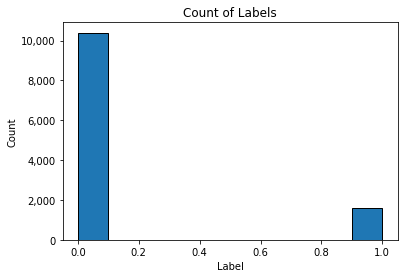

In [16]:
fig, ax = plt.subplots()
plt.hist(df_users['adopted_user'].astype('int'), edgecolor = 'k'); 
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Count of Labels');
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')));

Drop appropriate columns

In [17]:
cols_to_drop = ['user_id', 
                'name', 
                'email', 
                'org_cat',  # this was a created feature but did not improve the model score
#                 'org_id',
                'invited_by_user_id',
                'last_session_creation_time', 
                'last_session_creation_time_datetime',
                'creation_time',
                'creation_time_datetime',
                'in_df_eng']
df_users.drop(cols_to_drop, axis=1, inplace=True)

Correlation

In [18]:
print(f'Correlation with adopted_user')
df_users.corr(method ='pearson') ['adopted_user'].sort_values(ascending=False)[1:]

Correlation with adopted_user


last_session_creation_time_delta    0.268320
org_id                              0.064523
invited                             0.027671
opted_in_to_mailing_list            0.008097
enabled_for_marketing_drip          0.004653
creation_time_delta                -0.088006
Name: adopted_user, dtype: float64

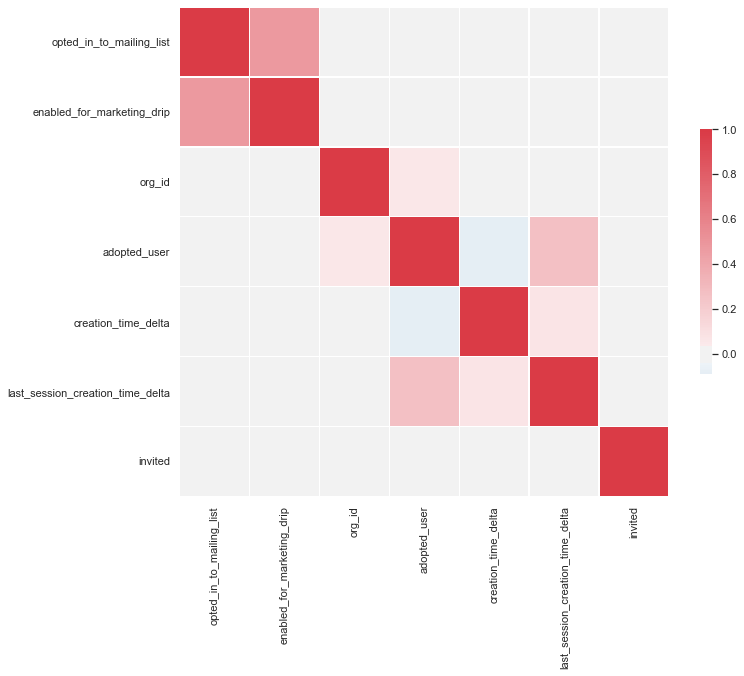

In [19]:
sns.set(style="white")

# Compute the correlation matrix
df_corr = df_users.corr()
# first_col = 'adopted_user'
# df_corr = df_corr.reindex(columns=sorted(df_corr.columns))

# x = ([first_col] + list([a for a in df_corr.columns if a != first_col]) )
# print(x)
# df_corr = df_corr.reindex(index=x)
# df_corr.drop('signup_date', inplace=True, axis=0)
# df_corr.drop('signup_date', inplace=True, axis=1)

# Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(df_corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(df_corr, cmap=cmap, annot=False, fmt="0.2f", center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"size": 8});

In [20]:
# code catagorical columns
cat_cols = list(df_users.select_dtypes(include=['object']).columns)
# if 'last_session_creation_time' in cat_cols: cat_cols.remove('last_session_creation_time')
# if 'creation_time' in cat_cols: cat_cols.remove('creation_time')
print(f'Catagorical columns: {cat_cols}')
for col in cat_cols:
    dummies = pd.get_dummies(df_users[col]).rename(columns=lambda x:  col + '_' + str(x))
    df_users = pd.concat([df_users, dummies], axis=1)
    df_users.drop([col], inplace=True, axis=1)
# code other dummy's
# code catagorical columns
dummy_cols = []  # originally using org_cat but did not improve model
print(f'Dummy columns: {dummy_cols}')
for col in dummy_cols:
    dummies = pd.get_dummies(df_users[col]).rename(columns=lambda x:  col + '_' + str(x))
    df_users = pd.concat([df_users, dummies], axis=1)
    df_users.drop([col], inplace=True, axis=1)
df_users.head()

Catagorical columns: ['creation_source']
Dummy columns: []


,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,creation_time_delta,last_session_creation_time_delta,invited,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,0.0,691.131979,5225.162153,1,1,0,0,0,0
1,0,0,1,1.0,533.126123,5203.156296,1,0,1,0,0,0
2,0,0,94,0.0,292.938484,4826.968657,1,0,1,0,0,0
3,0,0,1,0.0,355.309734,4890.339907,1,1,0,0,0,0
4,0,0,193,0.0,231.396447,4770.426620,1,1,0,0,0,0


In [21]:
scale_pos_weight_param = (df_users["adopted_user"].sum()) / (df_users.shape[0]) # positive samples / negative samples

Split data into train, validate and test (holdout)

In [22]:
# split the data
X = df_users.drop("adopted_user", axis=1)
y = df_users["adopted_user"]

X_train_and_valid, X_test, y_train_and_valid, y_test = train_test_split(
    X, y, test_size=0.1, random_state=50, stratify=y
)
# Separate remainder into training and validation data for optimization
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_and_valid,
    y_train_and_valid,
    test_size=0.2,
    random_state=50,
    stratify=y_train_and_valid,
)

print(f'{"Total Data:":<28}{X.shape[0]:7,.0f}{1:6.0%}  {"X"}')
bl()
print(f'{"Test (holdout) data:":<28}{X_test.shape[0]:7,.0f}{.1:6.0%}  {"X_test"}')
print(
    f'{"Train and Validation data:":<28}{X_train_and_valid.shape[0]:7,.0f}{.9:6.0%}  {"X_train_and_valid"}'
)
bl()
print(f'{"Train data:":<28}{X_train.shape[0]:7,.0f}{.72:6.0%}  {"X_train"}')
print(f'{"Validation data:":<28}{X_valid.shape[0]:7,.0f}{.18:6.0%}  {"X_valid"}')

Total Data:                  12,000  100%  X

Test (holdout) data:          1,200   10%  X_test
Train and Validation data:   10,800   90%  X_train_and_valid

Train data:                   8,640   72%  X_train
Validation data:              2,160   18%  X_valid


Classifier selection

In [23]:
accuracy_score_list = []
f1_score_list = []
precision_score_list = []
recall_score_list = []
roc_auc_score_list = []
models = []

print(
    f'{"classsifier":<30} {"accuracy":<6}  {"f1_score":<6}  {"precision":<7}    {"recall":<6}   {"roc_auc":<6}  {"time":<15}'
)


for idx, mod in enumerate(classification_algos):
    start = time.time()
    model = mod
    model.fit(X_train, y_train)
    y_valid_pred = model.predict(X_valid)
    end = time.time()
    recall_score_list.append(recall_score(y_valid, y_valid_pred))
    precision_score_list.append(precision_score(y_valid, y_valid_pred))
    f1_score_list.append(f1_score(y_valid, y_valid_pred))
    accuracy_score_list.append(accuracy_score(y_valid, y_valid_pred))
    roc_auc_score_list.append(roc_auc_score(y_valid, y_valid_pred))


    print(
        f"{classification_algos_name[idx]:<30} {accuracy_score_list[idx]:>8.2%}  {f1_score_list[idx]:>8.2%}  {precision_score_list[idx]:>9.2%}  {recall_score_list[idx]:>8.2%}  {roc_auc_score_list[idx]:>8.2%}  {end-start:.2f} sec"
    )

classsifier                    accuracy  f1_score  precision    recall   roc_auc  time           
KNeighborsClassifier             96.02%    83.71%     92.08%    76.74%    87.86%  0.14 sec
GaussianNB                       67.69%    39.72%     26.44%    79.86%    72.84%  0.01 sec
DecisionTreeClassifier           95.60%    83.07%     85.35%    80.90%    89.38%  0.03 sec
ExtraTreeClassifier              92.55%    71.50%     72.92%    70.14%    83.07%  0.01 sec
RandomForestClassifier           96.06%    83.69%     93.56%    75.69%    87.45%  0.70 sec
AdaBoostClassifier               96.30%    84.62%     94.83%    76.39%    87.87%  0.32 sec
GradientBoostingClassifier       96.16%    84.37%     92.18%    77.78%    88.38%  0.87 sec
XGBClassifier                    96.11%    84.09%     92.50%    77.08%    88.06%  0.34 sec
LGBMClassifier                   96.11%    84.62%     89.53%    80.21%    89.38%  0.28 sec


Best classifier: LGBMClassifier


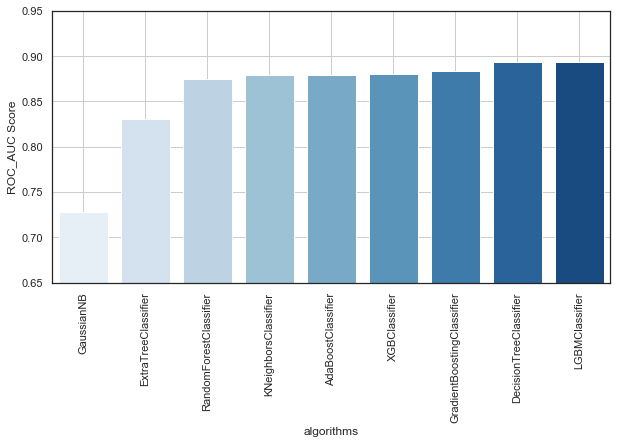

In [24]:
df_models = pd.DataFrame(
    {"algorithms": classification_algos_name, 
     "roc_auc": roc_auc_score_list,
      "recall": recall_score_list,
      "f1": f1_score_list,
      "precision": precision_score_list,
      "accuracy": accuracy_score_list}
)
df_models.set_index(keys='algorithms', drop=True, inplace=True)
df_models.sort_values(by='roc_auc', ascending=True, inplace=True)
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(df_models.index, df_models['roc_auc'], palette='Blues')
plt.xticks(rotation=90)
plt.ylim([.65,.95])
plt.ylabel('ROC_AUC Score')
plt.grid(True)

model_best_roc = df_models.index[-1]
print(f'Best classifier: {model_best_roc}')

In [25]:
for idx, mod in enumerate(classification_algos):
    if model_best_roc == classification_algos_name[idx]:
        model = mod
        print(f'Selecting {model_best_roc}')
        model.fit(X_train, y_train)
        
if hasattr(model, 'feature_importances_'):
    has_feature_importances_ = True
    print(f'{"":<3}{model_best_roc} has features_importances_')
else:
    has_feature_importances_ = False
    print(f'{"":<3}{model_best_roc} does NOT has features_importances_')

if hasattr(model, 'coef_'):
    has_coef_ = True
    print(f'{"":<3}{model_best_roc} has coef_')
else:
    has_coef_ = False
    print(f'{"":<3}{model_best_roc} does NOT has coef_')
bl()    
print(model)

Selecting LGBMClassifier
   LGBMClassifier has features_importances_
   LGBMClassifier does NOT has coef_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


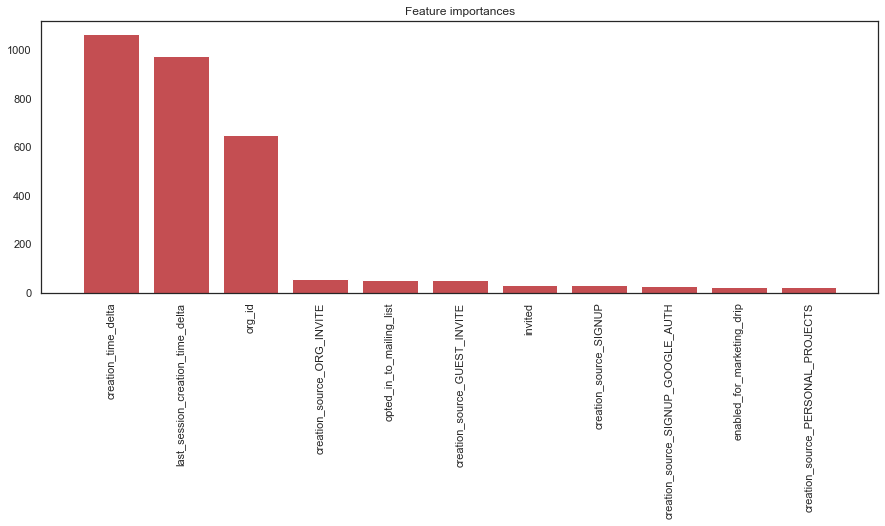


using LASSOCV to remove features

Best alpha using built-in LassoCV: 0.202370
Best score using built-in LassoCV: 0.087519

Lasso picked 3 variables and eliminated the other 8 variables

Dropping opted_in_to_mailing_list...
Dropping enabled_for_marketing_drip...
Dropping invited...
Dropping creation_source_GUEST_INVITE...
Dropping creation_source_ORG_INVITE...
Dropping creation_source_PERSONAL_PROJECTS...
Dropping creation_source_SIGNUP...
Dropping creation_source_SIGNUP_GOOGLE_AUTH...


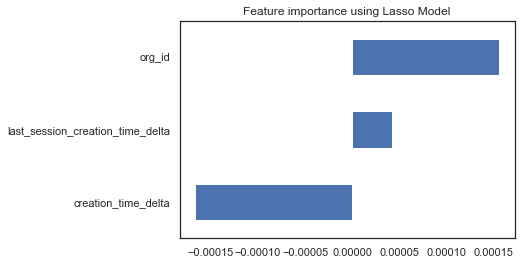

In [26]:
if has_feature_importances_:
    feat_imp_plot(X_train, model, X_train.shape[1], max_features=30)
    plt.show()
    bl()
print(f'using LASSOCV to remove features\n')
#     feat_imp_plot(X_train, model_for_fi, X_train.shape[1], max_features=30)
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
bl()
coef = pd.Series(reg.coef_, index = X.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables\n")

imp_coef = coef.sort_values()
imp_coef = imp_coef[imp_coef!=0]
#     matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

coef = pd.DataFrame(coef).reset_index()
coef.columns=['name','value']
for index, row in coef.iterrows():
    if row['value'] == 0:
        X.drop(row['name'], axis=1, inplace=True)
        print(f'Dropping {row["name"]}...')


The baseline score (roc_auc) on the validation set is 98.58%
The baseline training time is 0.27 seconds

               precision    recall  f1-score   support

         0.0     0.9700    0.9856    0.9777      1872
         1.0     0.8953    0.8021    0.8462       288

    accuracy                         0.9611      2160
   macro avg     0.9327    0.8938    0.9119      2160
weighted avg     0.9601    0.9611    0.9602      2160
 




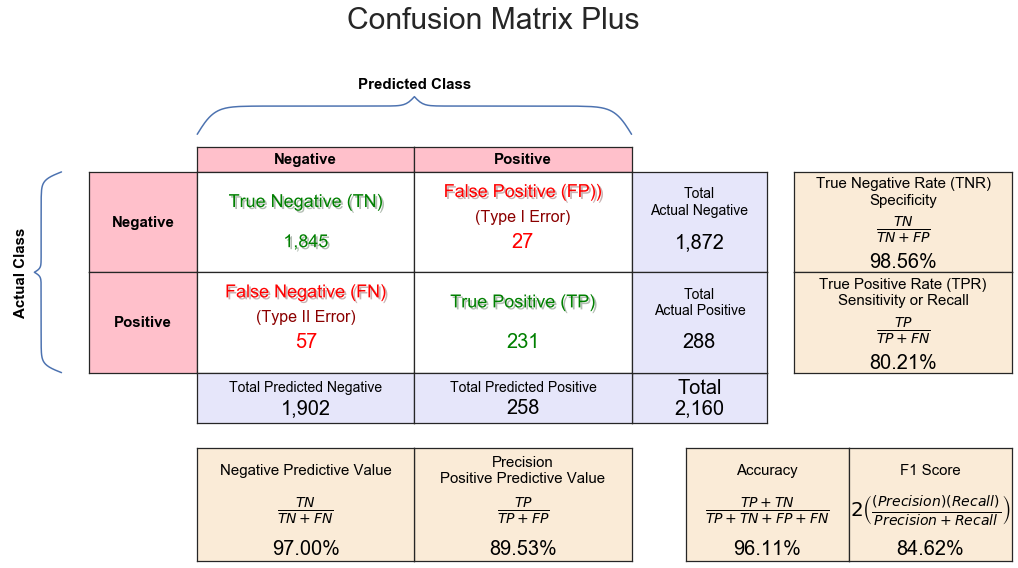

In [27]:
start = timer()
model.fit(X_train, y_train)
train_time = timer() - start

y_pred_prob = model.predict_proba(X_valid)[:, 1]
auc = roc_auc_score(y_valid, y_pred_prob)

print(f'The baseline score (roc_auc) on the validation set is {auc:.2%}')
print(f'The baseline training time is {train_time:.2f} seconds')

y_pred_prob = y_pred_prob.reshape(-1,1)
y_pred_class = binarize(y_pred_prob, 0.5)
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred_class).ravel()
print('\n', classification_report(y_valid, y_pred_class, digits=4), '\n');
_ = plot_cm_plus(tn=tn, fp=fp, fn=fn, tp=tp)

Optimize cutoff value

Optimal cutoff: 5.36%


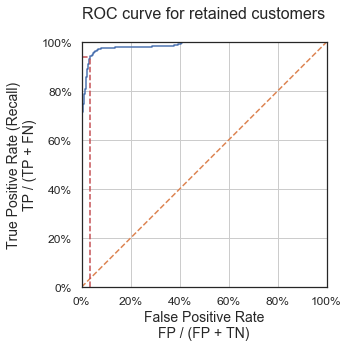

In [28]:
cutoff = plot_roc_curve(y_valid, y_pred_prob);
plt.plot()
print(f'Optimal cutoff: {cutoff:.2%}')

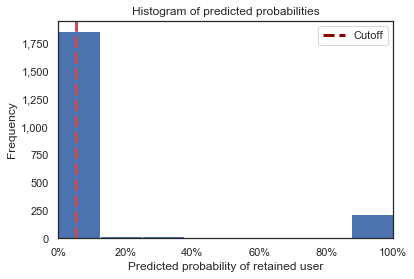



               precision    recall  f1-score   support

         0.0     0.9907    0.9647    0.9775      1872
         1.0     0.8042    0.9410    0.8672       288

    accuracy                         0.9616      2160
   macro avg     0.8974    0.9529    0.9224      2160
weighted avg     0.9658    0.9616    0.9628      2160
 




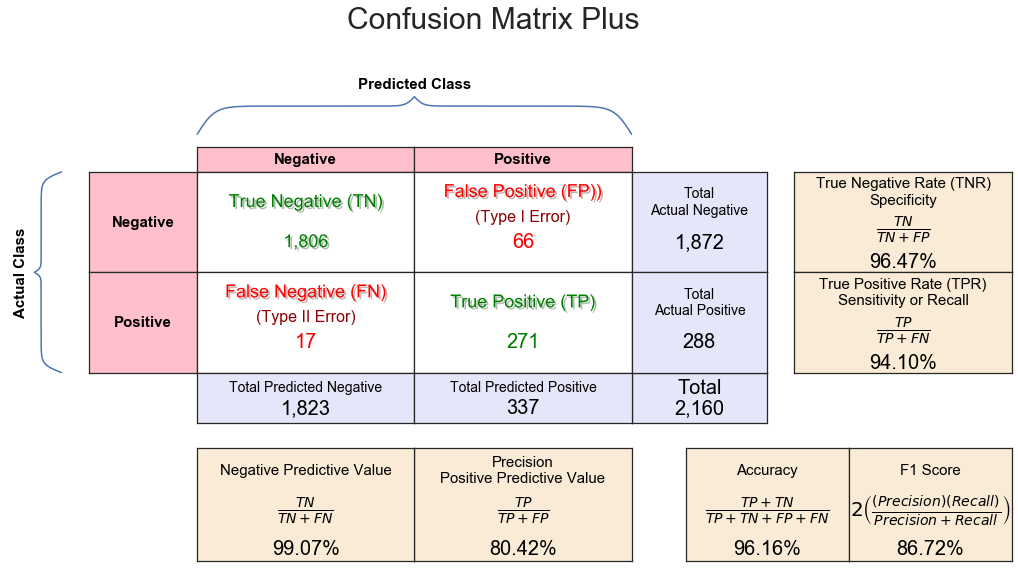

In [29]:
y_pred_class = binarize(y_pred_prob.reshape(-1,1), cutoff)
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred_class).ravel()
pred_prob_hist(X_valid, bins=8, xlabel='retained user', cutoff=cutoff)
print('\n', classification_report(y_valid, y_pred_class, digits=4), '\n')
_ = plot_cm_plus(tn=tn, fp=fp, fn=fn, tp=tp)
bl()

Refit model with train and vaild data

In [30]:
model.fit(X_train_and_valid, y_train_and_valid)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


               precision    recall  f1-score   support

         0.0     0.9939    0.9452    0.9690      1040
         1.0     0.7299    0.9625    0.8302       160

    accuracy                         0.9475      1200
   macro avg     0.8619    0.9538    0.8996      1200
weighted avg     0.9587    0.9475    0.9504      1200
 




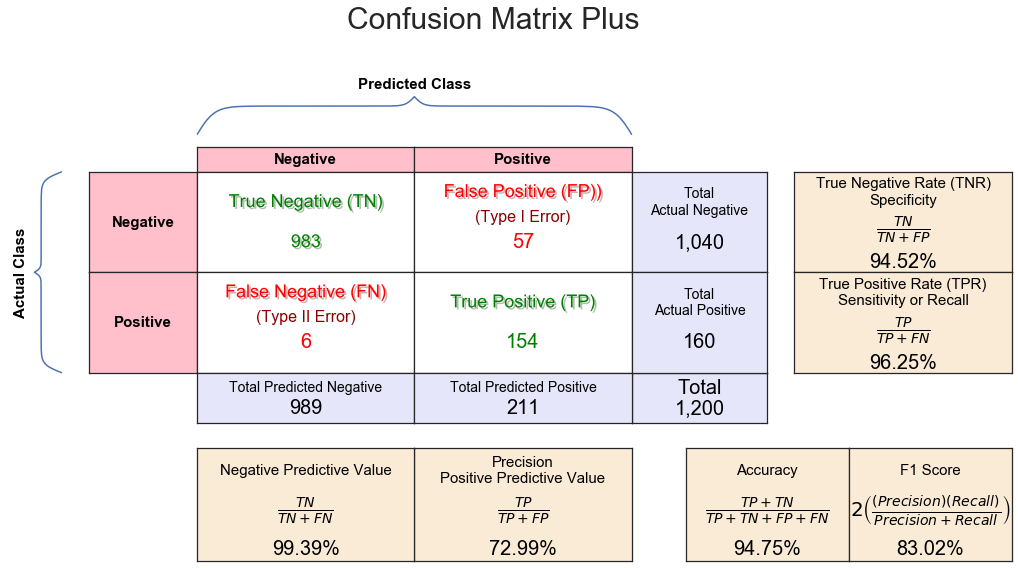

In [31]:
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred_class = binarize(y_pred_prob.reshape(-1,1), cutoff)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_class).ravel()
print('\n', classification_report(y_test, y_pred_class, digits=4), '\n')
fig = plot_cm_plus(tn=tn, fp=fp, fn=fn, tp=tp)
fig.savefig('images/Optimize_cutoff_value')
bl()